## Face Recognition Classifier using Principal Component Analysis (PCA) and Linear Discriminant Analysis (LDA) for feature space reduction coupled with a Nearest Neighbor Classifier using Facepix dataset (https://cubic.asu.edu/content/facepix-database)
### Tejas Pant
### 29th Nov 2018

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
import glob
import pickle
import os.path

In [2]:
trainPath = '../ECE661_2018_hw10_DB1/train/'
testPath = '../ECE661_2018_hw10_DB1/test/'

#Get vector length of image based on dimensions
images = glob.glob(trainPath + '*.png')
image = cv2.imread(images[0])
imageVecLen = image.shape[0]*image.shape[1]

#Number of classes of Images
nClass = 30
#Number of samples per class
nSamp = 21 

#true labels in test set
trueLabel = np.zeros(nClass*nSamp,dtype=int)
for i in range(nClass):
    idxs = nSamp * i
    idxe = idxs + nSamp
    trueLabel[idxs:idxe] = i+1

In [3]:
#Calculates the mean image m and vector X = [x_1 - m, x_2 - m, ....] for training set
def preProcessImages(path, nClass, nSamp):  
    images = glob.glob(path + '*.png')
    image = cv2.imread(images[0])
    imagesVec = np.zeros((image.shape[0]*image.shape[1], nClass * nSamp))
    img_count = 0
    
    #Vectorize each of the images and normalize it
    for iCl in range(nClass):
        idx_start = nSamp * iCl
        for iSamp in range(nSamp):
            img = cv2.imread(images[idx_start + iSamp])
            img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            img_vec = np.reshape(img_gray,(img_gray.shape[0]*img_gray.shape[1]))
            img_vec_norm = img_vec / np.linalg.norm(img_vec)
            imagesVec[:,img_count] = img_vec_norm
            img_count += 1 
    
    #Calculate mean image
    meanImg = np.mean(imagesVec,1)
    XImages = np.zeros_like(imagesVec)
    
    #Get the matrix X
    for i in range(imagesVec.shape[1]):
        XImages[:,i] = imagesVec[:,i] - meanImg  
        
    return XImages, imagesVec, meanImg

#PCA calculation for training set
#Returns feature values for training images, y and matrix Wp
def PCATrainData(imagesVec, p):
    UeigVal, UeigVec = np.linalg.eig(np.matmul(np.transpose(imagesVec),imagesVec))
    #Get index of top p number of largest eigen values
    UeigValIndx = UeigVal.argsort()[::-1][:p]
    #u eigen vectors
    UeigVecSort = UeigVec[:,UeigValIndx]
    #w eigen vector
    WeigVecSort = np.matmul(imagesVec,UeigVecSort)
    #Normalize w eigen vectors
    WeigVecSortNorm = np.zeros_like(WeigVecSort)
    for i in range(WeigVecSort.shape[1]):
        WeigVecSortNorm[:,i] = WeigVecSort[:,i]/np.linalg.norm(WeigVecSort[:,i])
        
    #Calculate feature values based on eigen vectors
    y = np.matmul(np.transpose(WeigVecSortNorm),imagesVec)
    return y, WeigVecSortNorm

#PCA calculation for test set
#Returns feature values y for test images
def PCATestData(path, meanImgTrain, Wp, nClass, nSamp):  
    images = glob.glob(path + '*.png')
    image = cv2.imread(images[0])
    Xtest = np.zeros((image.shape[0]*image.shape[1], nClass * nSamp))
    img_count = 0
    
    #Vectorize test set images and subtract mean image from training set
    for iCl in range(nClass):
        idx_start = nSamp * iCl
        for iSamp in range(nSamp):
            img = cv2.imread(images[idx_start + iSamp])
            img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            img_vec = np.reshape(img_gray,(img_gray.shape[0]*img_gray.shape[1]))
            img_vec_norm = img_vec / np.linalg.norm(img_vec)
            Xtest[:,img_count] = img_vec_norm - meanImgTrain
            img_count += 1 
            
    #Feature values for test set
    y = np.matmul(np.transpose(Wp),Xtest) 
    return y

#Nearest neigbor classifier for comparing test feature values with training feature values
def NearestNeighborClassifier(yTrain, yTest, trueLabel):
    predictedLabel = np.zeros(nClass*nSamp,dtype=int)
    nTrain = yTrain.shape[1]
    nTest = yTest.shape[1]
    euclid_dt = np.zeros((nTrain,nTest))
    for i in range(nTest):
        for j in range(nTrain):
            euclid_dt[i,j] = np.linalg.norm(yTest[:,i]-yTrain[:,j])
        euclid_dt_sort_idx = np.argsort(euclid_dt[i,:])
        predictedLabel[i] = trueLabel[euclid_dt_sort_idx[0]]

    #Calculate accuracy
    accuracy = np.sum(np.equal(predictedLabel,trueLabel))/len(trueLabel)
    return accuracy

#LDA calculation from training set
#Returns feature values for training images and matrix Wp
def LCATrainData(X, xi, meanImg, nClass, nSamp, p):
    
    #Calculate class mean
    meanImgClass = np.zeros((xi.shape[0],nClass))
    M = np.zeros_like(meanImgClass)
    for i in range(nClass):
        idxs = nSamp * i
        idxe = idxs + nSamp
        meanImgClass[:,i] = np.mean(xi[:,idxs:idxe],1)
        M[:,i] = meanImgClass[:,i] - meanImg
    
    #Eigen decompositon for Sb
    UeigVal, UeigVec = np.linalg.eig(np.matmul(np.transpose(M),M))
    UeigValIndx = UeigVal.argsort()[::-1][:len(UeigVal)]
    UeigVecSort = UeigVec[:,UeigValIndx]
    UeigValSort = UeigVal[UeigValIndx]
    
    #Calculate Z based on eigen values of Sb
    Y = np.matmul(M, UeigVecSort)
    UeigValSortForDbSqrt = np.power(UeigValSort,-0.5)
    Db = np.diag(UeigValSort)
    Db_sqrt = np.diag(UeigValSortForDbSqrt)
    Z = np.matmul(Y, Db_sqrt)
    
    #Calculation of Xw
    Xw = xi - np.repeat(meanImgClass,nSamp,1)
    
    #Eigen value decomposition of Z^T * S_w * Z
    t1 = np.matmul(np.transpose(Z),Xw)
    t2 = np.transpose(t1)
    UeigValLCA, UeigVecLCA = np.linalg.eig(np.matmul(t1,t2))
    UeigValLCASortIndx = UeigValLCA.argsort()
    UeigVecLCASort = UeigVecLCA[:,UeigValLCASortIndx]
    U_hat = UeigVecLCASort[:,0:p]
    
    #Determine Wp
    WpT = np.matmul(np.transpose(U_hat),np.transpose(Z))
    Wp = np.transpose(WpT)
    Wp_norm = np.zeros_like(Wp)
    for i in range(p):
        Wp_norm[:,i] = Wp[:,i] / np.linalg.norm(Wp)
        
    #Calculate y for training set
    y = np.matmul(np.transpose(Wp_norm),X) 
    return y, Wp_norm

In [28]:
#PCA calculation for different values of subspace dimensions

#Calculate X = [x_i-m], xi and mean image m of training set 
X_images_train, x_images_train, meanImage_Train = preProcessImages(trainPath,nClass,nSamp)

#Max value of subspace dimension
pPCA_maxVal = 20
PCA_accuracy = np.zeros(pPCA_maxVal)
for pPCA in range(1,pPCA_maxVal+1):
    print("Number of Features = ", pPCA)
    yTrain = np.zeros((pPCA,nClass*nSamp))
    WpTrain = np.zeros((imageVecLen,pPCA))
    yTest = np.zeros_like(yTrain)
    
    #Calculate feature values and Wp for training set
    yTrain, WpTrain = PCATrainData(X_images_train, pPCA)
    
    #Calculate feature values for test set (Same method as PCA)
    yTest = PCATestData(testPath, meanImage_Train, WpTrain, nClass, nSamp)
    
    #Nearest neighbor classifier
    PCA_accuracy[pPCA-1] = NearestNeighborClassifier(yTrain, yTest, trueLabel)
    print("Done")

Number of Features =  1
Done
Number of Features =  2
Done
Number of Features =  3
Done
Number of Features =  4
Done
Number of Features =  5
Done
Number of Features =  6
Done
Number of Features =  7
Done
Number of Features =  8
Done
Number of Features =  9
Done
Number of Features =  10
Done
Number of Features =  11
Done
Number of Features =  12
Done
Number of Features =  13
Done
Number of Features =  14
Done
Number of Features =  15
Done
Number of Features =  16
Done
Number of Features =  17
Done
Number of Features =  18
Done
Number of Features =  19
Done
Number of Features =  20
Done


In [27]:
#LDA calculation for different values of subspace dimensions

#Calculate X = [x_i-m], xi and mean image m of training set 
X_images_train, x_images_train, meanImage_Train = preProcessImages(trainPath,nClass,nSamp)

#Max value of subspace dimension
pLDA_maxVal = 20
LDA_accuracy = np.zeros(pLDA_maxVal)
for pLDA in range(1,pLDA_maxVal+1):
    print("Number of Features = ", pLDA)
    yTrain = np.zeros((pLDA,nClass*nSamp))
    WpTrain = np.zeros((imageVecLen,pLDA))
    yTest = np.zeros_like(yTrain)
    
    #Calculate feature values and Wp for training set
    yTrain, WpTrain = LCATrainData(X_images_train, x_images_train, meanImage_Train, nClass, nSamp, pLDA)
    
    #Calculate feature values for test set (Same method as PCA)
    yTest = PCATestData(testPath, meanImage_Train, WpTrain, nClass, nSamp) 
    
    #Nearest neighbor classifier
    LDA_accuracy[pLDA-1] = NearestNeighborClassifier(yTrain, yTest, trueLabel)

Number of Features =  1
Number of Features =  2
Number of Features =  3
Number of Features =  4
Number of Features =  5
Number of Features =  6
Number of Features =  7
Number of Features =  8
Number of Features =  9
Number of Features =  10
Number of Features =  11
Number of Features =  12
Number of Features =  13
Number of Features =  14
Number of Features =  15
Number of Features =  16
Number of Features =  17
Number of Features =  18
Number of Features =  19
Number of Features =  20


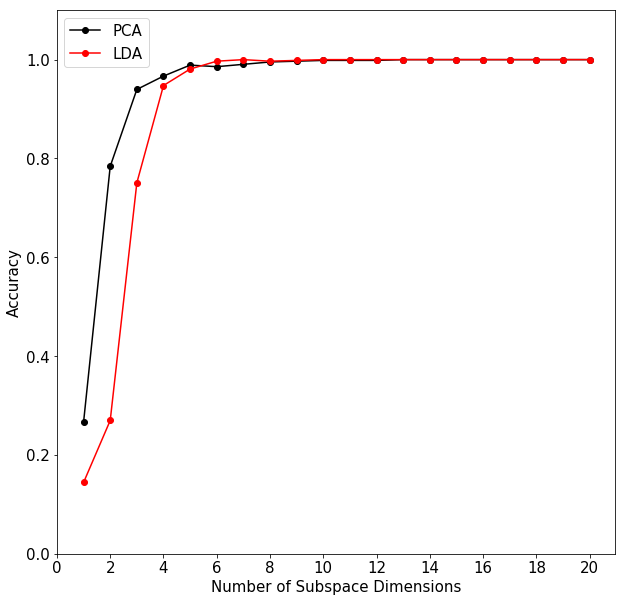

In [31]:
#Plot comparison of performance of PCA and LDA for different values of subspace dimension
plt.figure(figsize=(10,10))
plt.plot((range(1,pPCA_maxVal+1)),PCA_accuracy,'ko-', label = 'PCA')
plt.plot((range(1,pLDA_maxVal+1)),LDA_accuracy,'ro-', label = 'LDA')
plt.ylim([0,1.1])
plt.xlabel('Number of Subspace Dimensions',fontsize=15)
plt.ylabel('Accuracy',fontsize=15)
plt.legend(fontsize=15)
plt.xticks(np.arange(0, 22, step=2),fontsize=15)
plt.yticks(fontsize=15)
plt.show()